### Setup

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric Temporal

In [12]:
!pip install torch_geometric

In [13]:
import torch

TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

# Construct the installation command
install_command = f"pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html"

# Execute the command
!{install_command}

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


In [14]:
import numpy as np
import os

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### `ASLInMemoryDataset` Class

In [15]:
import json
from itertools import repeat
from torch_geometric.data import InMemoryDataset, Data
from tqdm.notebook import tqdm
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, remove_self_loops

class ASLInMemoryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(ASLInMemoryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.sign_to_label_map, self.total_num_classes = self._load_metadata()

    def _save_metadata(self, sign_to_label_map, total_num_classes):
        metadata_path = os.path.join(self.processed_dir, 'metadata.pt')
        torch.save({'sign_to_label_map': sign_to_label_map, 'total_num_classes': total_num_classes}, metadata_path)

    def _load_metadata(self):
        metadata_path = os.path.join(self.processed_dir, 'metadata.pt')
        if os.path.exists(metadata_path):
            metadata = torch.load(metadata_path)
            return metadata.get('sign_to_label_map', {}), metadata.get('total_num_classes', 0)
        return {}, 0

    @property
    def raw_file_names(self):
        return [os.path.splitext(filename)[0] for filename in os.listdir(self.raw_dir)]

    @property
    def processed_file_names(self):
        return ['processed_data.pt']

    def download(self):
        # We're using local files, so no need to implement download logic
        pass

    def process(self):
        data_list = []

        loader = ASLDatasetLoader(self.raw_dir)
        self._sign_to_label = loader.sign_to_label
        dataset = loader.get_dataset()

        # If you want to add a progress bar, use tqdm here
        # dataset = tqdm(dataset, desc="Processing dataset", leave=False)

        data_list.extend(dataset)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

        # After processing, save the sign_to_label and num_classes
        self._save_metadata(loader.sign_to_label, loader.number_of_classes())

    def len(self):
        return len(self._data.y)

    def get(self, idx):
        data = Data()
        for key in self._data.keys():
            item, slices = self._data[key], self.slices[key]
            s = list(repeat(slice(None), item.dim()))
            s[self._data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        return data

    def sign_to_label(self):
        return self.sign_to_label_map

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [16]:
class ASLDatasetLoader:
    # Define natural connections as class attributes
    HAND_CONNECTIONS = frozenset([
      # Left hand palm
      ("left_hand-0", "left_hand-1"),
      ("left_hand-0", "left_hand-5"),
      ("left_hand-9", "left_hand-13"),
      ("left_hand-13", "left_hand-17"),
      ("left_hand-5", "left_hand-9"),
      ("left_hand-0", "left_hand-17"),
      # Left hand thumb
      ("left_hand-1", "left_hand-2"),
      ("left_hand-2", "left_hand-3"),
      ("left_hand-3", "left_hand-4"),
      # Left hand index finger
      ("left_hand-5", "left_hand-6"),
      ("left_hand-6", "left_hand-7"),
      ("left_hand-7", "left_hand-8"),
      # Left hand middle finger
      ("left_hand-9", "left_hand-10"),
      ("left_hand-10", "left_hand-11"),
      ("left_hand-11", "left_hand-12"),
      # Left hand ring finger
      ("left_hand-13", "left_hand-14"),
      ("left_hand-14", "left_hand-15"),
      ("left_hand-15", "left_hand-16"),
      # Left hand pinky
      ("left_hand-17", "left_hand-18"),
      ("left_hand-18", "left_hand-19"),
      ("left_hand-19", "left_hand-20"),
      # Right hand palm
      ("right_hand-0", "right_hand-1"),
      ("right_hand-0", "right_hand-5"),
      ("right_hand-9", "right_hand-13"),
      ("right_hand-13", "right_hand-17"),
      ("right_hand-5", "right_hand-9"),
      ("right_hand-0", "right_hand-17"),
      # Right hand thumb
      ("right_hand-1", "right_hand-2"),
      ("right_hand-2", "right_hand-3"),
      ("right_hand-3", "right_hand-4"),
      # Right hand index finger
      ("right_hand-5", "right_hand-6"),
      ("right_hand-6", "right_hand-7"),
      ("right_hand-7", "right_hand-8"),
      # Right hand middle finger
      ("right_hand-9", "right_hand-10"),
      ("right_hand-10", "right_hand-11"),
      ("right_hand-11", "right_hand-12"),
      # Right hand ring finger
      ("right_hand-13", "right_hand-14"),
      ("right_hand-14", "right_hand-15"),
      ("right_hand-15", "right_hand-16"),
      # Right hand pinky
      ("right_hand-17", "right_hand-18"),
      ("right_hand-18", "right_hand-19"),
      ("right_hand-19", "right_hand-20"),
    ])

    POSE_CONNECTIONS = frozenset([
      ("pose-0", "pose-1"),
      ("pose-1", "pose-2"),
      ("pose-2", "pose-3"),
      ("pose-3", "pose-7"),
      ("pose-0", "pose-4"),
      ("pose-4", "pose-5"),
      ("pose-5", "pose-6"),
      ("pose-6", "pose-8"),
      ("pose-9", "pose-10"),
      ("pose-11", "pose-12"),
      ("pose-11", "pose-13"),
      ("pose-13", "pose-15"),
      ("pose-15", "pose-17"),
      ("pose-12", "pose-14"),
      ("pose-14", "pose-16"),
      ("pose-16", "pose-18"),
      ("pose-11", "pose-23"),
      ("pose-12", "pose-24"),
      ("pose-23", "pose-24"),
    ])

    FACE_CONNECTIONS = frozenset([
      # Connections for FACEMESH_LIPS using available landmarks
      ("face-61", "face-146"), ("face-146", "face-91"), ("face-91", "face-181"),
      ("face-181", "face-84"), ("face-84", "face-17"), ("face-17", "face-314"),
      ("face-314", "face-405"), ("face-405", "face-321"), ("face-321", "face-375"),
      ("face-375", "face-291"), ("face-78", "face-95"), ("face-95", "face-88"),
      ("face-88", "face-178"), ("face-178", "face-87"), ("face-87", "face-14"),
      ("face-14", "face-317"), ("face-317", "face-402"), ("face-402", "face-318"),
      ("face-318", "face-324"), ("face-324", "face-308"),

      # Connections for FACEMESH_LEFT_EYE using available landmarks
      ("face-263", "face-249"), ("face-388", "face-387"), ("face-387", "face-386"),
      ("face-386", "face-385"), ("face-385", "face-384"), ("face-384", "face-398"),

      # Connections for FACEMESH_LEFT_EYEBROW using available landmarks
      ("face-276", "face-283"), ("face-300", "face-293"), ("face-293", "face-334"),
      ("face-334", "face-296"), ("face-296", "face-336"),

      # Connections for FACEMESH_RIGHT_EYE using available landmarks
      ("face-33", "face-7"), ("face-246", "face-161"), ("face-161", "face-160"),
      ("face-160", "face-159"), ("face-159", "face-158"), ("face-158", "face-157"),
      ("face-157", "face-173"),

      # Connections for FACEMESH_RIGHT_EYEBROW using available landmarks
      ("face-46", "face-53"), ("face-70", "face-63"), ("face-63", "face-105"),
      ("face-105", "face-66"), ("face-66", "face-107"),

      # Connections for FACEMESH_FACE_OVAL using available landmarks
      ("face-10", "face-338"), ("face-338", "face-297"), ("face-297", "face-332"),
      ("face-332", "face-284"), ("face-284", "face-251"), ("face-251", "face-389"),
      ("face-389", "face-356"), ("face-356", "face-454"), ("face-454", "face-323"),
      ("face-323", "face-361"), ("face-361", "face-288"), ("face-288", "face-397"),
      ("face-397", "face-365"), ("face-365", "face-379"), ("face-379", "face-378"),
      ("face-378", "face-400"), ("face-400", "face-377"), ("face-377", "face-152"),
      ("face-152", "face-148"), ("face-148", "face-176"), ("face-176", "face-149"),
      ("face-149", "face-150"), ("face-150", "face-136"), ("face-136", "face-172"),
      ("face-172", "face-58"), ("face-58", "face-132"), ("face-132", "face-93"),
      ("face-93", "face-234"), ("face-234", "face-127"), ("face-127", "face-162"),
      ("face-162", "face-21"), ("face-21", "face-54"), ("face-54", "face-103"),
      ("face-103", "face-67"), ("face-67", "face-109"), ("face-109", "face-10"),
    ])

    def __init__(self, directory_path, min_examples_per_class=2, max_files=-1):
        self.directory_path = directory_path
        self.min_examples_per_class = min_examples_per_class
        self.max_files = max_files
        self.sign_to_label = self._create_sign_to_label_map()

    def _create_sign_to_label_map(self):
        signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]
        return {sign: i for i, sign in enumerate(signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)

        sign_name = data["sign"]
        num_examples = len(data["examples"])
        print(f"Loaded sign '{sign_name}' with {num_examples} examples")

        return data if num_examples >= self.min_examples_per_class else None

    def _augment_data(self, frame_data, rotation_range=10, translation_range=0.05, scaling_range=0.1, jittering_range=0.01, noise_scale=0.01, mirroring=False):
        """
        Augment the frame data with various techniques including rotation, translation, scaling, jittering, noise injection, and mirroring.

        :param frame_data: Dictionary containing frame landmarks and deltas.
        :param rotation_range: Maximum rotation angle in degrees.
        :param translation_range: Maximum translation as a fraction of landmark range.
        :param scaling_range: Maximum scaling factor.
        :param jittering_range: Range for jittering.
        :param noise_scale: Scale of the random noise to be added.
        :param mirroring: Whether to mirror the landmarks (simulate opposite hand).
        :return: Augmented frame data.
        """
        # Extract landmarks
        landmarks = np.array([[landmark['x'], landmark['y']] for landmark in frame_data['landmarks']])
        centroid = np.mean(landmarks, axis=0)

        # Jittering
        jittering = np.random.uniform(-jittering_range, jittering_range, landmarks.shape)
        landmarks += jittering

        # Random rotation
        theta = np.radians(np.random.uniform(-rotation_range, rotation_range))
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        landmarks = np.dot(landmarks - centroid, rotation_matrix) + centroid

        # Random translation
        max_translation = translation_range * (landmarks.max(axis=0) - landmarks.min(axis=0))
        translations = np.random.uniform(-max_translation, max_translation, size=landmarks.shape[1])
        landmarks += translations

        # Random scaling
        scale = np.random.uniform(1 - scaling_range, 1 + scaling_range)
        landmarks = centroid + scale * (landmarks - centroid)

        # Noise Injection
        noise = np.random.normal(0, noise_scale, landmarks.shape)
        landmarks += noise

        # Mirroring (if applicable)
        if mirroring:
            landmarks[:, 0] = -landmarks[:, 0] + 2 * centroid[0]  # Reflect x-coordinates

        # Update the landmarks in frame_data
        for i, landmark in enumerate(frame_data['landmarks']):
            landmark['x'], landmark['y'] = landmarks[i]

        return frame_data


    def _create_graph_from_frame(self, sign_name, sign_data):
        graphs = []

        for example in sign_data["examples"]:
            all_features = []  # Combined list for landmarks, velocities, and accelerations
            edges = []

            for frame in example["frames"]:
                for landmark_data in frame["landmarks"]:
                    # Extract spatial coordinates
                    landmark_features = [landmark_data["x"], landmark_data["y"]]

                    # Extract temporal data (velocity and acceleration)
                    temporal_data = next((item for item in frame["temporal"] if item["landmark"] == landmark_data["landmark"]), None)
                    if temporal_data:
                        velocity = [temporal_data["velocity"]["x"], temporal_data["velocity"]["y"]]
                        acceleration = [temporal_data["acceleration"]["x"], temporal_data["acceleration"]["y"]]
                    else:
                        velocity = [0, 0]
                        acceleration = [0, 0]

                    # Combine spatial and temporal features
                    combined_features = landmark_features + velocity + acceleration
                    all_features.append(combined_features)

                # Add spatial edges within the frame using natural connections
                for i in range(len(frame["landmarks"])):
                    for j in range(len(frame["landmarks"])):
                        if i != j:
                            connection = (frame["landmarks"][i]["landmark"], frame["landmarks"][j]["landmark"])
                            if connection in self.HAND_CONNECTIONS or \
                              connection in self.POSE_CONNECTIONS or \
                              connection in self.FACE_CONNECTIONS:
                                edges.append([len(all_features) - len(frame["landmarks"]) + i,
                                              len(all_features) - len(frame["landmarks"]) + j])

            # Add temporal edges between frames within each example
            for i in range(len(example["frames"]) - 1):
                for j in range(len(frame["landmarks"])):
                    start_index = i * len(frame["landmarks"]) + j
                    end_index = (i + 1) * len(frame["landmarks"]) + j
                    edges.append([start_index, end_index])

            # Create the graph
            x = torch.tensor(all_features, dtype=torch.float)
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

            # Append the graph for the current example to the list of graphs
            graphs.append(Data(x=x, edge_index=edge_index, y=y))

        return graphs

    def get_dataset(self):
        dataset = []
        file_count = 0

        for filename in os.listdir(self.directory_path):
            if 0 <= self.max_files <= file_count:
                break  # Stop if max_files limit is reached

            sign_name = os.path.splitext(filename)[0]
            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)
            file_count += 1

            if sign_data is None:
                print(f"Skipping sign '{sign_name}' due to insufficient examples")
                continue

            # Retrieve a list of graphs, one for each example
            graphs = self._create_graph_from_frame(sign_name, sign_data)

            # Debugging: Check the number of graphs created for the current sign
            print(f"Sign '{sign_name}': Created {len(graphs)} graphs")

            dataset.extend(graphs)  # Extend the dataset with the list of graphs

        return dataset

    def number_of_classes(self):
        return len(self.sign_to_label)

### `ASLGraphClassifier` Class

The `ASLGraphClassifier`, features deeper GCN layers and additional channels to capture intricate data patterns potentially. It takes a PyG `Data` object as input, and its forward pass emits class logits.

**Methods**:

- `forward`: Details the forward pass, accepting a PyG `Data` object. Two GCN layers with subsequent batch normalization and dropout layers process the input. Post global max-pooling, two linear layers coupled with dropout ensure final classification, leading to log-softmax outputs.

In [17]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, global_max_pool, LayerNorm

class ASLGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ASLGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 512)
        self.bn1 = BatchNorm(512)
        self.conv2 = GCNConv(512, 1024)
        self.bn2 = BatchNorm(1024)
        self.ln1 = LayerNorm(1024)  # Layer normalization
        self.lin1 = torch.nn.Linear(1024, 512)
        self.ln2 = LayerNorm(512)  # Layer normalization
        self.lin2 = torch.nn.Linear(512, num_classes)

        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.ln1(x)  # Apply layer normalization
        x = self.dropout(x)

        x = global_max_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = self.ln2(x)  # Apply layer normalization
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [18]:
import datetime

CHECKPOINT_DIR = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/ModelCheckpoints"

def save_checkpoint(model, optimizer, epoch, loss):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint-{timestamp}-epoch-{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_latest_checkpoint(model, optimizer):
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    if not checkpoints:
        return 0  # No checkpoint found

    latest_checkpoint = max(checkpoints, key=lambda f: os.path.getmtime(os.path.join(CHECKPOINT_DIR, f)))
    checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Resuming from checkpoint: {checkpoint_path}")
    return epoch

In [19]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from collections import Counter

def stratified_data_split(data_list, test_size=0.2):
    labels = [data.y.item() for data in data_list]
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)
    return train_data, test_data

def validate(loader, model, device):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def train(train_dataset, test_dataset, num_classes=6, EPOCHS=100, LEARNING_RATE=0.001):
    train_labels = [data.y.item() for data in train_dataset]
    test_labels = [data.y.item() for data in test_dataset]

    print("Training label distribution:", Counter(train_labels))
    print("Test label distribution:", Counter(test_labels))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_features = train_dataset[0].x.size(1)
    model = ASLGraphClassifier(num_features=num_features, num_classes=num_classes).to(device)

    initial_batch_size = 64
    final_batch_size = 16
    warmup_epochs = 5
    initial_lr = 0.00001
    validate_every_n_batches = 60
    patience=15
    weight_decay=1e-5
    reduction_factor=0.8

    current_batch_size = initial_batch_size
    train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=patience, verbose=True)

    l1_lambda = 1e-6
    l2_lambda = 1e-5

    best_val_accuracy = 0
    epochs_without_improvement = 0
    max_epochs_without_improvement = 5

    model.train()
    start_epoch = load_latest_checkpoint(model, optimizer)
    for epoch in range(start_epoch, EPOCHS):
        total_loss = 0
        correct_train = 0
        total_train = 0
        batch_count = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)

            l1_reg = sum(param.abs().sum() for param in model.parameters())
            l2_reg = sum(param.pow(2).sum() for param in model.parameters())
            loss = F.nll_loss(out, batch.y) + l1_lambda * l1_reg + l2_lambda * l2_reg

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            total_loss += loss.item()
            pred_train = out.argmax(dim=1)
            correct_train += int((pred_train == batch.y).sum())
            total_train += batch.y.size(0)

            batch_count += 1
            if batch_count % validate_every_n_batches == 0:
                val_accuracy = validate(test_loader, model, device)
                print(f"Validation Accuracy after {batch_count} batches: {val_accuracy:.4f}")

        if epoch < warmup_epochs:
            lr = initial_lr + (LEARNING_RATE - initial_lr) * (epoch / warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if epoch % 10 == 0 and current_batch_size > final_batch_size:
            current_batch_size //= 2
            train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        val_accuracy = validate(test_loader, model, device)

        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        scheduler.step(val_accuracy)

        # Save checkpoint periodically
        if epoch % 5 == 0:  # For example, every 5 epochs
            save_checkpoint(model, optimizer, epoch, avg_loss)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_improvement:
            print("Early stopping triggered.")
            break

    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    for batch in test_loader:
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            correct += pred.eq(batch.y).sum().item()

    accuracy = correct / len(test_dataset)
    print(f"Accuracy: {accuracy}")
    print("Sample predictions:", all_preds[:20])
    print("Sample true labels:", all_labels[:20])

    return model, all_preds, all_labels, accuracy

In [20]:
MAX_FILES = 6
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/processed-40-500-3"

# Create an instance of the ASLInMemoryDataset
dataset = ASLInMemoryDataset(root=directory_path)
# Accessing sign_to_label and num_classes
sign_to_label_map = dataset.sign_to_label_map
total_num_classes = dataset.total_num_classes

Processing...


Loaded sign 'dad' with 378 examples
Sign 'dad': Created 378 graphs
Loaded sign 'TV' with 385 examples
Sign 'TV': Created 385 graphs
Loaded sign 'flower' with 396 examples
Sign 'flower': Created 396 graphs
Loaded sign 'dance' with 312 examples
Sign 'dance': Created 312 graphs
Loaded sign 'cry' with 390 examples
Sign 'cry': Created 390 graphs
Loaded sign 'callonphone' with 385 examples
Sign 'callonphone': Created 385 graphs


Done!


In [21]:
# Split the dataset into training and validation subsets
train_data, val_data = stratified_data_split(dataset)

In [22]:
# Train the model using the datasets
model, all_preds, all_labels, accuracy = train(train_data, val_data, num_classes=total_num_classes, EPOCHS=100, LEARNING_RATE=0.001)

Training label distribution: Counter({2: 317, 4: 312, 1: 308, 5: 308, 0: 302, 3: 249})
Test label distribution: Counter({2: 79, 4: 78, 1: 77, 5: 77, 0: 76, 3: 63})
Epoch 0, Loss: 1.1038, Training Accuracy: 0.1765, Validation Accuracy: 0.1689
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/ModelCheckpoints/checkpoint-20231213-061030-epoch-0.pth
Epoch 1, Loss: 1.8592, Training Accuracy: 0.1782, Validation Accuracy: 0.2311
Epoch 2, Loss: 1.8631, Training Accuracy: 0.1943, Validation Accuracy: 0.2044
Epoch 3, Loss: 1.7237, Training Accuracy: 0.2884, Validation Accuracy: 0.2800
Epoch 4, Loss: 1.4528, Training Accuracy: 0.4432, Validation Accuracy: 0.5067
Epoch 5, Loss: 1.2602, Training Accuracy: 0.5184, Validation Accuracy: 0.5044
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/ModelCheckpoints/checkpoint-20231213-063816-epoch-5.pth
Epoch 6, Loss: 1.1263, Training Accuracy: 0.5768, Validation Accuracy: 0.5600
Epoch 7, Loss: 0.9993, Train

In [31]:
print(model)

ASLGraphClassifier(
  (conv1): GCNConv(6, 512)
  (bn1): BatchNorm(512)
  (conv2): GCNConv(512, 1024)
  (bn2): BatchNorm(1024)
  (ln1): LayerNorm(1024, affine=True, mode=graph)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (ln2): LayerNorm(512, affine=True, mode=graph)
  (lin2): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [23]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/SavedModels/Best-GNN-5-Weights.pth')

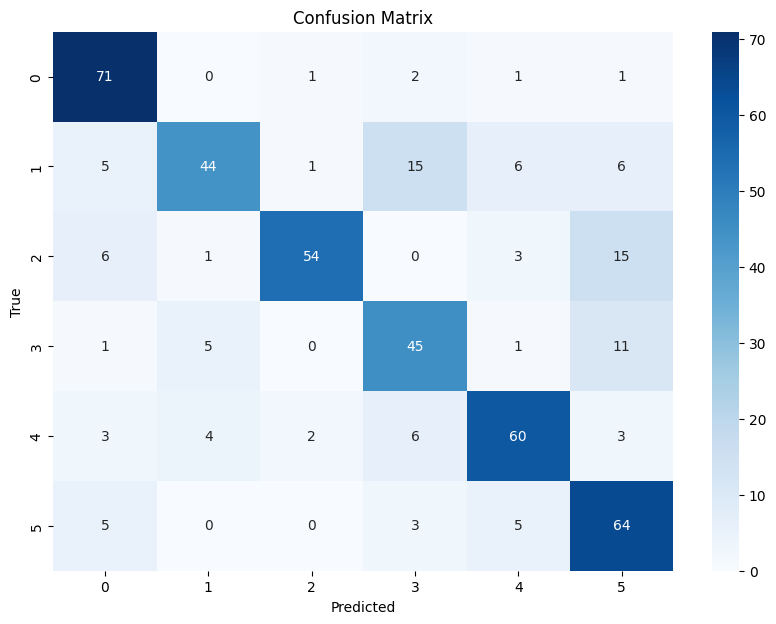

Accuracy for class 0 (dad): 93.42%
Accuracy for class 1 (TV): 57.14%
Accuracy for class 2 (flower): 68.35%
Accuracy for class 3 (dance): 71.43%
Accuracy for class 4 (cry): 76.92%
Accuracy for class 5 (callonphone): 83.12%

Classification Report:

              precision    recall  f1-score   support

         dad       0.78      0.93      0.85        76
          TV       0.81      0.57      0.67        77
      flower       0.93      0.68      0.79        79
       dance       0.63      0.71      0.67        63
         cry       0.79      0.77      0.78        78
 callonphone       0.64      0.83      0.72        77

    accuracy                           0.75       450
   macro avg       0.76      0.75      0.75       450
weighted avg       0.77      0.75      0.75       450



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted(dataset.sign_to_label().items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [25]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [26]:
N = 10 if MAX_FILES > 50 else MAX_FILES
print_top_misclassified_classes(y_true, y_pred, sign_to_label_map, N=N, zero_division=1)


Classification Report:

              precision    recall  f1-score   support

         dad       0.78      0.93      0.85        76
          TV       0.81      0.57      0.67        77
      flower       0.93      0.68      0.79        79
       dance       0.63      0.71      0.67        63
         cry       0.79      0.77      0.78        78
 callonphone       0.64      0.83      0.72        77

    accuracy                           0.75       450
   macro avg       0.76      0.75      0.75       450
weighted avg       0.77      0.75      0.75       450


Top 6 misclassified classes:
1. TV - Misclassification rate: 0.43
2. flower - Misclassification rate: 0.32
3. dance - Misclassification rate: 0.29
4. cry - Misclassification rate: 0.23
5. callonphone - Misclassification rate: 0.17
6. dad - Misclassification rate: 0.07
